In [1]:

import pylabnet.hardware.awg.zi_hdawg as zi_hdawg
from pylabnet.utils.logging.logger import LogClient


import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import time

from IPython.display import clear_output, display

import pyvisa
from pylabnet.utils.logging.logger import LogClient
from pylabnet.network.client_server import agilent_e4405B
import pylabnet.hardware.spectrum_analyzer.agilent_e4405B as sa_hardware

#!pip install seaborn
import itertools as it
import pandas as pd
import seaborn as sns

from pylabnet.utils.logging.logger import LogService
from pylabnet.network.core.generic_server import GenericServer
import os
import sys
from pylabnet.utils.iq_upconversion.optimizer import IQOptimizer, IQOptimizer_GD, IQOptimizer_GD_multifreq
#from pylabnet.utils.iq_upconversion.optimizer_temp import IQOptimizer as IQ_w_ports
#from pylabnet.utils.iq_upconversion.optimizer_temp import IQOptimizer_GD
from pylabnet.network.client_server import HMC_T2220

from pylabnet.network.client_server.agilent_83732b import Client

In [2]:
import csv
import numpy as np
from scipy.interpolate import interp1d
VA = np.zeros(100)
PA = np.zeros(100)
with open("D:\\Dropbox\\Dropbox (Lukin SiV)\\SiV Quick Sharing\\B16 python experiments\\powerfile\\power.csv", newline='') as csvfile:
    reader = csv.DictReader(csvfile)

    ii = 0
    for row in reader:
        VA[ii] = float(row['0.0'])
        PA[ii] = float(row['1.0'])
        ii = ii+1

inv_fun = interp1d(PA[:-1]**(1/2), VA[:-1], kind='linear')


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Dropbox\\Dropbox (Lukin SiV)\\SiV Quick Sharing\\B16 python experiments\\powerfile\\power.csv'

In [3]:
inv_fun(0.695)

NameError: name 'inv_fun' is not defined

# Instantiante HDAWG

In [2]:
dev_id = 'dev8227'
# Instantiate Hardware class
hd = zi_hdawg.Driver(dev_id, None)

# Select channel grouping
#hd.set_channel_grouping(0)

#hd.enable_output(2)
#hd.enable_output(3)

c:\Users\Brain\pylabnet\venv\dev\lib\site-packages\zhinst\utils.py:168: UserWarning: There is a mismatch between the versions of the API and Data Server. The API reports version `20.07' (revision: 200702238) whilst the Data Server has version `21.02' (revision 210215439). See the ``Compatibility'' Section in the LabOne Programming Manual for more information.
  warnings.warn(message)


# Connect to MW client

In [4]:
# Connect to MW source client
#mw_client = HMC_T2220.Client(
#    host='140.247.189.82',
#    port=2552
#)

# Connect to MW source client
mw = Client(
    host='192.168.50.104', 
    port=5912
)

In [5]:
# Check that MW source is set to correct power
# mw_client.output_on()
pow = 25  # -20 dBm
mw.set_power(pow)
mw.output_on()
#mw_client.get_power()

# Connect to Spectrum Analyzer

In [6]:
sa = agilent_e4405B.Client(
    host='localhost',
    port=12352
)

# Reset spectrum analzyer
sa.write('*RST')

(6, <StatusCode.success: 0>)

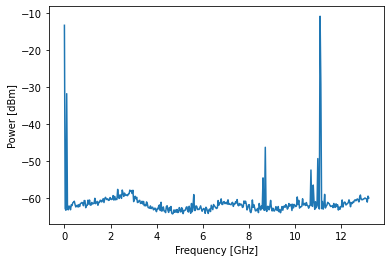

In [7]:
sa.set_reference_level(-7)
sa.plot_trace()


# Optimize

In [8]:
HDAWG_ports = [3,4]
param_guess = ([85, 1, 0.6, 0.05, -0.02])
hd.setd('sines/{}/amplitudes/{}'.format(HDAWG_ports[1]-1, np.mod(HDAWG_ports[1]-1,2)), 2*param_guess[2]*(1/(1+param_guess[1])))

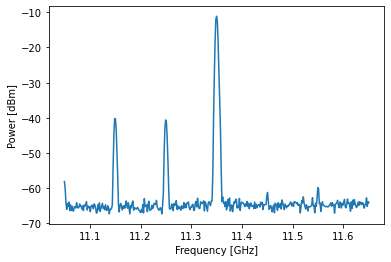

In [19]:
opt2 = IQOptimizer(mw, hd, sa, 11.25e9, 100e6,  dc_i_window = 0.2, dc_q_window = 0.2, phase_window = 50, max_iterations = 3, q_window = 0.34, max_lower_sideband_pow = -60, max_carrier_pow = -60, param_guess = ([90, 1, 0.75, 0, 0]), awg_delay_time=0.01, averages=2, HDAWG_ports=[3,4], oscillator=2)

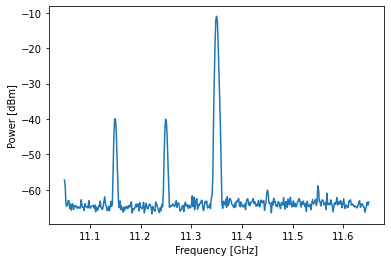

In [17]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.25e9, 100e6, param_guess = ([90, 1, 0.75, 0.02, 0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[3,4], oscillator=2, min_power=-65, phase_step = 3, vi_step=0.02, vq_step=0.02, max_iterations = 30)

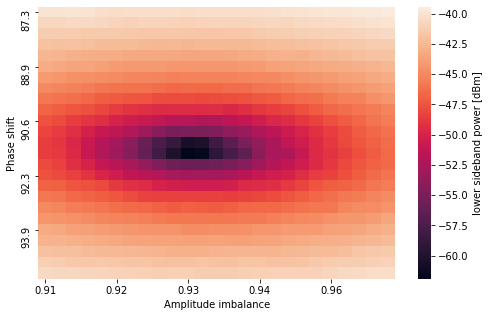

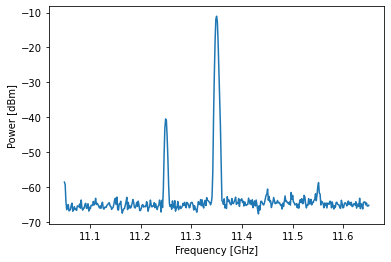

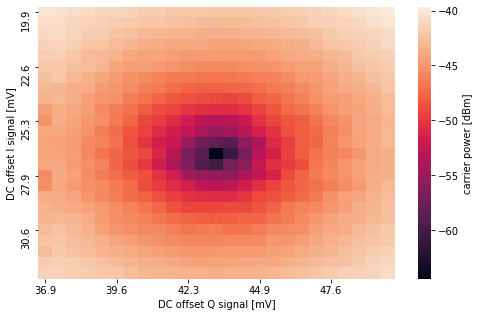

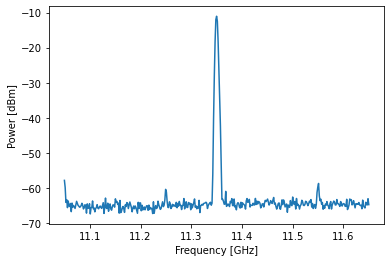

405.6557357311249


In [20]:
import time
start = time.time()
opt2.opt()
print(time.time()-start)

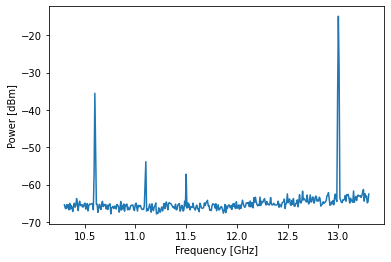

In [23]:
sa.plot_trace()

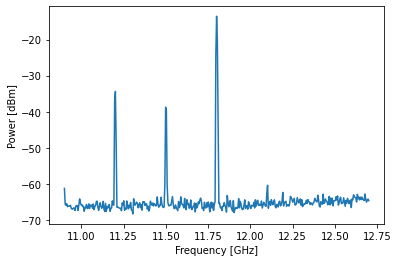

In [20]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.5e9, 300e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[3,4], oscillator=2, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

705.4315748214722


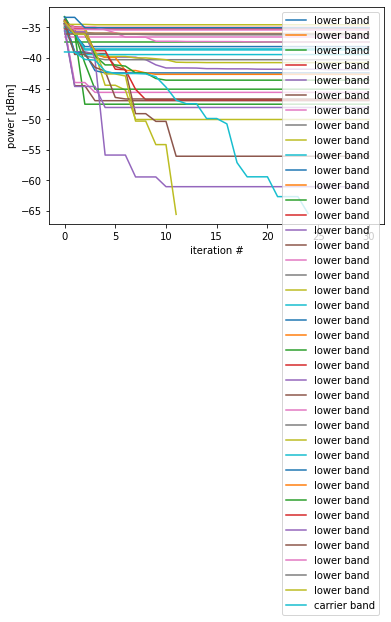

In [21]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

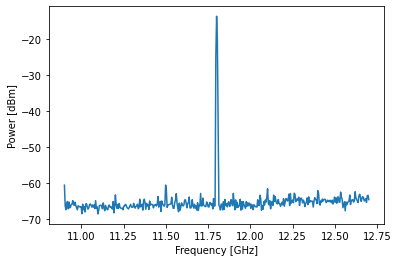

In [23]:
sa.plot_trace()

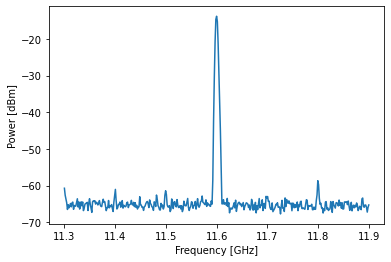

In [19]:
sa.set_reference_level(-9)
sa.plot_trace()

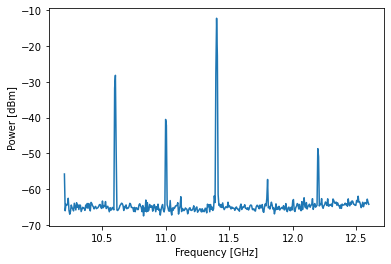

In [10]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11e9, 400e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

91.08602166175842


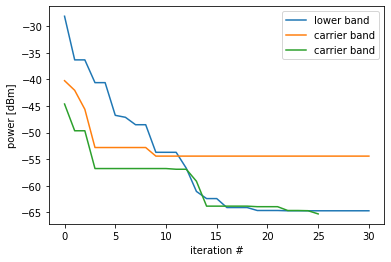

In [11]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

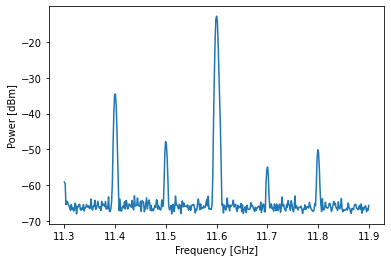

In [12]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.5e9, 100e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

47.26195526123047


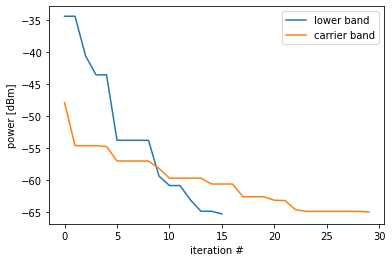

In [13]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

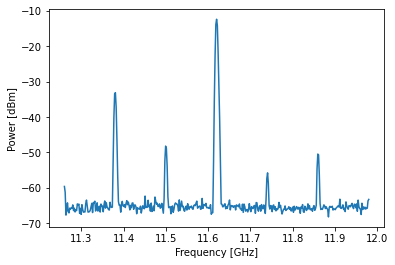

In [14]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.5e9, 120e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

51.85113501548767


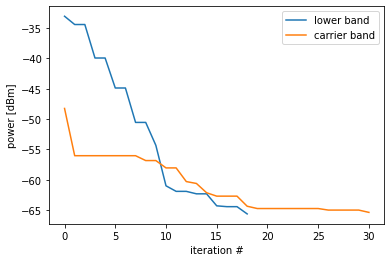

In [15]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

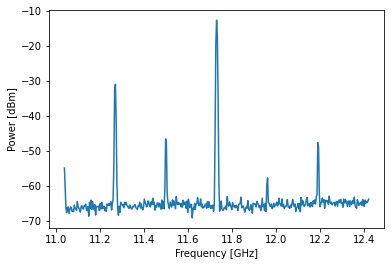

In [16]:
opt1 = IQOptimizer_GD(mw, hd, sa, 11.5e9, 230e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

118.22234535217285


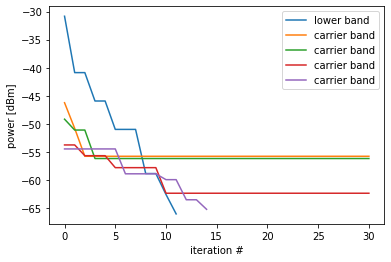

In [17]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

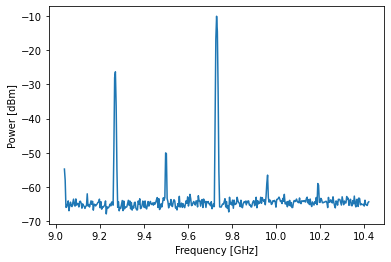

In [18]:
opt1 = IQOptimizer_GD(mw, hd, sa, 9.5e9, 230e6, param_guess = ([85, 1, 0.6, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=1, min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

48.07945227622986


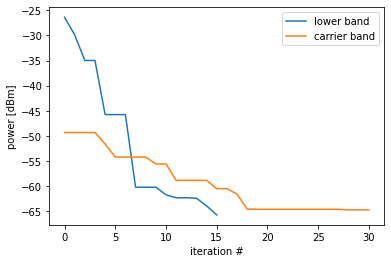

In [19]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)

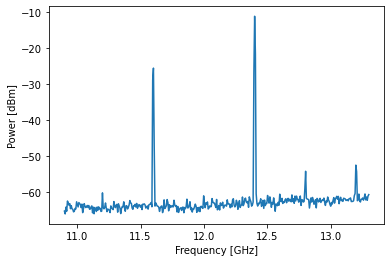

In [9]:
sa.plot_trace()

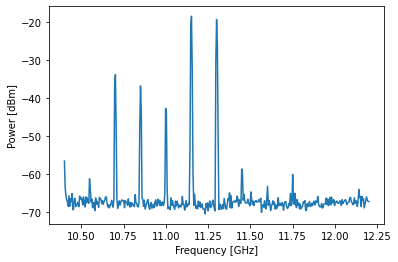

In [37]:
opt1 = IQOptimizer_GD_multifreq(mw, hd, sa, 11e9, [150e6, 300e6], param_guess = ([90, 90, 1, 1, 0.05, -0.02]), awg_delay_time=0.01, averages=10, HDAWG_ports=[1,2], oscillator=[1,2], min_power=-65, vi_step=0.005, vq_step=0.005, max_iterations = 30)

58.780874729156494


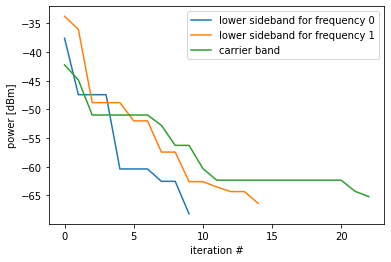

In [38]:
import time
start = time.time()
opt1.opt()
print(time.time()-start)


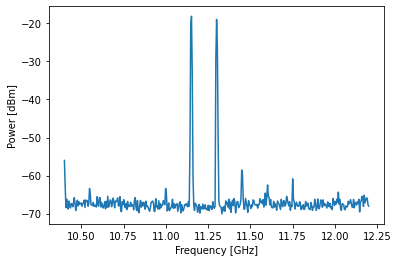

In [39]:
sa.plot_trace()